In [4]:
#import
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from osgeo import ogr, osr
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
import shapely.wkt
ox.config(log_console=True, use_cache=True)
ox.__version__

'0.10'

The example is from here: https://github.com/gboeing/osmnx-examples/blob/master/notebooks/13-isolines-isochrones.ipynb

## Functions

In [8]:
# get one color for each isochrone
iso_colours = ox.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)

# isochrone function
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, centre_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lines.append(LineString([f,t]))

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

## from place name

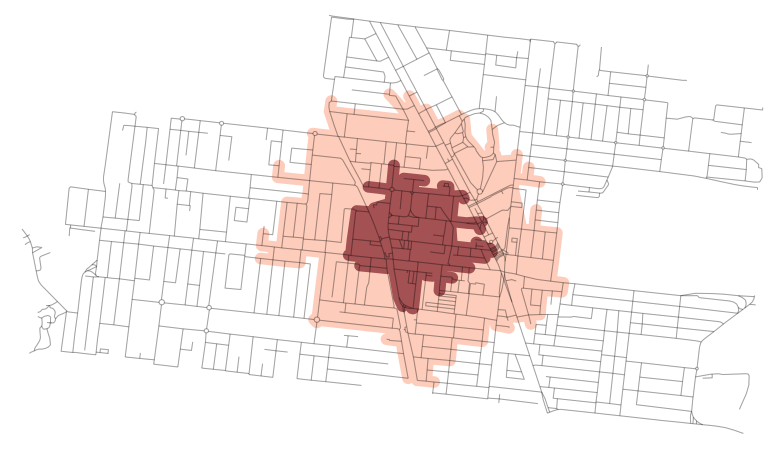

In [9]:
# configure the place, network type, trip times, and travel speed
place = 'Moonee Ponds, Victoria, Australia'
network_type = 'walk'
trip_times = [5, 10] #in minutes
travel_speed = 4.8 #walking speed in km/hour


# download the street network
G = ox.graph_from_place(place, network_type=network_type)

# find the centremost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes['geometry'].unary_union.centroid.xy
centre_node = ox.get_nearest_node(G, (y[0], x[0]))
G = ox.project_graph(G)

# add an edge attribute for time in minutes required to traverse each edge
metres_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / metres_per_minute

# make the polygons    
isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
fig, ax = ox.plot_graph(G, fig_height=8, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colours):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

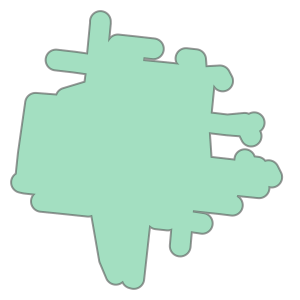

In [10]:
# 400m - 5 minutes
isochrone_polys[1]

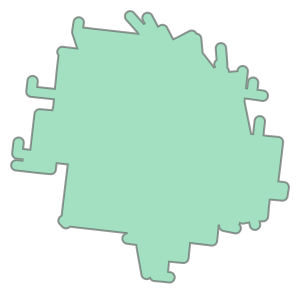

In [11]:
# 800m - 10 minutes
isochrone_polys[0]

## export
shapely doesn't have a crs. need to export the wkt then reimport!

In [12]:
# to text
f = open('wkt\mp_800m.txt', 'w') 
f.write(isochrone_polys[0].wkt)  
f.close() 

f = open('wkt\mp_400m.txt', 'w') 
f.write(isochrone_polys[1].wkt)  
f.close() 

In [13]:
# read wkt and use it to create a shapely polygon P
with open('wkt\mp_400m.txt') as f:
    x = f.readline()
P = shapely.wkt.loads(x)

In [14]:
# Now convert it to a shapefile with OGR    
sr = osr.SpatialReference()
# or sr.ImportFromProj4(edges.crs)
sr.ImportFromProj4('+proj=utm +zone=55 +ellps=WGS84 +datum=WGS84 +units=m +no_defs')
driver = ogr.GetDriverByName('ESRI Shapefile')
ds = driver.CreateDataSource('shp\moonee_ponds_400m.shp')
layer = ds.CreateLayer('route', sr, ogr.wkbPolygon)# Add one attribute
layer.CreateField(ogr.FieldDefn('id', ogr.OFTInteger))
defn = layer.GetLayerDefn()

## If there are multiple geometries, put the "for" loop here

# Create a new feature (attribute and geometry)
feat = ogr.Feature(defn)
feat.SetField('id', 123)

# Make a geometry, from Shapely object
geom = ogr.CreateGeometryFromWkb(P.wkb)
feat.SetGeometry(geom)
layer.CreateFeature(feat)
feat =  None 

# Save and close the data source
ds = None

## From centoids

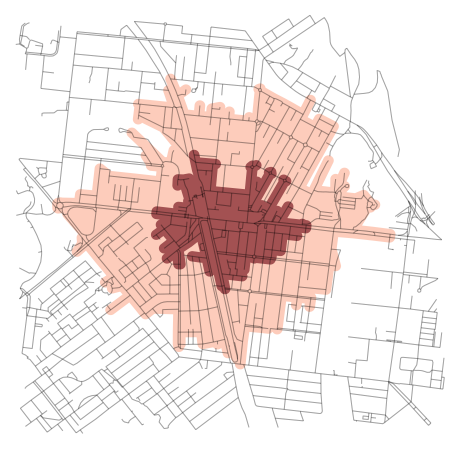

In [15]:
# configure the place, network type, trip times, and travel speed
coords = (-37.788375, 144.930499) #Flemington library
network_type = 'walk'
trip_times = [5, 10] #in minutes
travel_speed = 4.8 #walking speed in km/hour

# download the street network
G = ox.graph_from_point(coords, network_type=network_type)

# run from the centroid
centre_node = ox.get_nearest_node(G, (coords[0], coords[1]))
G = ox.project_graph(G)

# add an edge attribute for time in minutes required to traverse each edge
metres_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / metres_per_minute
    
# make the polygons    
isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
fig, ax = ox.plot_graph(G, fig_height=8, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colours):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

### test of iteration

In [30]:
multiple_coords = ((-37.773981, 144.915669), (-37.765443, 144.863070)) #Ascot Vale and Avondale Heights libraries

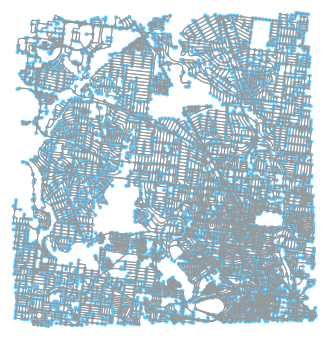

(<Figure size 405.698x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11a70248908>)

In [75]:
# the area - Moonee Valley
mv = ox.graph_from_bbox(-37.705, -37.796, 144.949, 144.84, network_type='walk')
mv_projected = ox.project_graph(mv)
ox.plot_graph(mv_projected)

In [70]:
# test function to do multiple ones - Moonee Valley
def iterate_multiple_coords(the_coordinates):
    network_type = 'walk'
    trip_times = [5, 10] #in minutes
    travel_speed = 4.8 #walking speed in km/hour
    metres_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
    poly_list = []
    for i in the_coordinates:
        centre_node = ox.get_nearest_node(mv, (i[0], i[1]))
        # add an edge attribute for time in minutes required to traverse each edge
        for u, v, k, data in mv_projected.edges(data=True, keys=True):
            data['time'] = data['length'] / metres_per_minute
        # make the polygons    
        isochrone_polys = make_iso_polys(mv_projected, edge_buff=25, node_buff=0, infill=True)
        poly_list.append(isochrone_polys)
    return(poly_list)

In [71]:
#list of shapely objects
test = iterate_multiple_coords(multiple_coords)

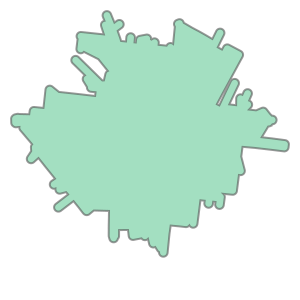

In [74]:
test[0][0]

to do:
* work out how to get the multiple list objects to wkt
* get back in to shp
* dissolve (or something like that in fewer steps)